In [1]:
import os
import math
import json
import random
import h5py
from glob import glob
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

In [2]:
data = pd.read_csv('data/gap_filling_station_info.csv', parse_dates=['date'])

stations = ['ABZ', 'ALE', 'AMA', 'AMM', 'ASP', 'BEI', 'BOT', 'BSL', 'DEL', 'EGB',
            'FKL', 'HAD', 'HEL', 'HPB', 'HRW', 'HYY', 'KCE', 'KPZ', 'MAR', 'MHD', 
            'MLP', 'MUK', 'NAN', 'NEU', 'POV', 'SAO', 'SCH', 'SGP', 'UAE', 'PRL',
            'VAR', 'VHL', 'VIE', 'WAL', 'ZOT']

# filter
data = data[data.station.isin(stations)]

aerosols = ['aermr01', 'aermr02', 'aermr03', 'aermr04', 'aermr05', 'aermr06', 
            'aermr07', 'aermr08', 'aermr09', 'aermr10', 'aermr11']

gases = ['co', 'c5h8', 'c10h16', 'nh3', 'no', 'no2', 'so2']

met = ['d2m', 't2m', 'blh', 'rh', 'wind_speed', 'crwc']
        
loc = ['latitude', 'longitude', 'altitude']

env_types = ['env_type_coastal', 'env_type_remote', 'env_type_rural', 'env_type_rural_regional_background', 'env_type_urban', 'env_type_urban_background']

feature_list = gases + met + aerosols + loc + env_types

log_transform = aerosols + gases + met

# log-transforming the selected variables, setting negative values to the minimum observed positive value
for v in log_transform:
    data[v] = np.log(data[v].where(data[v] > 0, data[v][data[v] > 0].min()))    

n100_positive_min = data['n100'][data['n100'] > 0].min()
data['n100'] = data['n100'].apply(lambda x: np.log(n100_positive_min) if (x < 0) else x)
data['n100'] = data['n100'].apply(lambda x: np.log(x) if pd.notnull(x) else np.nan)

data.rename(columns={'n100': 'target'}, inplace=True)

# standard scaling attempted and performs worse than log scaling

# std_columns = gases + met + aerosols + ['target']

# Calculate mean and standard deviation for each feature
# means = data[std_columns].mean()
# stds = data[std_columns].std()

# Store the values in a dictionary for each feature
# scaler_params = {}
# for feature in std_columns:
#     scaler_params[feature] = {
#         'mean': means[feature],
#         'std': stds[feature]
#     }

# Standardize the data
# for feature in std_columns:
#     data[feature] = (data[feature] - scaler_params[feature]['mean']) / scaler_params[feature]['std']

data.head()

,id,station,date,latitude,longitude,target,aermr01,aermr02,aermr03,aermr04,...,rh,wind_speed,altitude,environment_type,env_type_coastal,env_type_remote,env_type_rural,env_type_rural_regional_background,env_type_urban,env_type_urban_background
0,ABZ-2012-01-26 18:00:00,ABZ,2012-01-26 18:00:00,50.57,12.99,1.057219,-0.356469,-0.350541,-0.225362,-0.229432,...,0.469184,-0.312166,545,urban_background,0,0,0,0,0,1
1,ABZ-2012-01-26 21:00:00,ABZ,2012-01-26 21:00:00,50.57,12.99,0.937720,-0.350019,-0.344068,-0.227120,-0.229435,...,0.590460,-0.340121,545,urban_background,0,0,0,0,0,1
2,ABZ-2012-01-27 00:00:00,ABZ,2012-01-27 00:00:00,50.57,12.99,0.556498,-0.381945,-0.376068,-0.230308,-0.229395,...,0.779539,-0.529427,545,urban_background,0,0,0,0,0,1
3,ABZ-2012-01-27 03:00:00,ABZ,2012-01-27 03:00:00,50.57,12.99,0.388061,-0.403428,-0.397609,-0.231492,-0.229258,...,0.759908,-0.712384,545,urban_background,0,0,0,0,0,1
4,ABZ-2012-01-27 06:00:00,ABZ,2012-01-27 06:00:00,50.57,12.99,0.500268,-0.410379,-0.404574,-0.231963,-0.228930,...,0.750992,-0.640707,545,urban_background,0,0,0,0,0,1


In [3]:
# Drop NaNs
data = data.dropna(axis=0)

# Compute the difference between consecutive rows
differences = data['target'].diff()

# Filter out rows where the difference is zero
data = data[differences != 0]

In [4]:
# calculate time difference between consecutive rows
time_diff = data.groupby('station')['date'].diff()

# find rows where time difference is greater than 3 hours
gap_rows = time_diff > pd.Timedelta('3 hours')

# create a new segment every time a gap is detected
segment_ids = gap_rows.groupby(data['station']).cumsum()

# create group_ids column by concatenating station name and segment_ids
data['group_ids'] = data['station'] + '_segment_' + segment_ids.astype(str)

# group by station and group_ids, and assign a unique index to each row within each group
data['time_idx'] = data.groupby(['station', 'group_ids']).cumcount()

In [5]:
data.head()

,id,station,date,latitude,longitude,target,aermr01,aermr02,aermr03,aermr04,...,altitude,environment_type,env_type_coastal,env_type_remote,env_type_rural,env_type_rural_regional_background,env_type_urban,env_type_urban_background,group_ids,time_idx
0,ABZ-2012-01-26 18:00:00,ABZ,2012-01-26 18:00:00,50.57,12.99,1.057219,-0.356469,-0.350541,-0.225362,-0.229432,...,545,urban_background,0,0,0,0,0,1,ABZ_segment_0,0
1,ABZ-2012-01-26 21:00:00,ABZ,2012-01-26 21:00:00,50.57,12.99,0.937720,-0.350019,-0.344068,-0.227120,-0.229435,...,545,urban_background,0,0,0,0,0,1,ABZ_segment_0,1
2,ABZ-2012-01-27 00:00:00,ABZ,2012-01-27 00:00:00,50.57,12.99,0.556498,-0.381945,-0.376068,-0.230308,-0.229395,...,545,urban_background,0,0,0,0,0,1,ABZ_segment_0,2
3,ABZ-2012-01-27 03:00:00,ABZ,2012-01-27 03:00:00,50.57,12.99,0.388061,-0.403428,-0.397609,-0.231492,-0.229258,...,545,urban_background,0,0,0,0,0,1,ABZ_segment_0,3
4,ABZ-2012-01-27 06:00:00,ABZ,2012-01-27 06:00:00,50.57,12.99,0.500268,-0.410379,-0.404574,-0.231963,-0.228930,...,545,urban_background,0,0,0,0,0,1,ABZ_segment_0,4


In [6]:
data.groupby('station')['group_ids'].nunique()

station
ABZ    144
ALE    140
AMA     76
AMM     14
ASP     38
BEI     41
BOT     47
BSL     16
DEL     68
EGB     20
FKL     18
HAD     16
HEL     97
HPB     32
HRW     72
HYY     91
KCE    176
KPZ    171
MAR     39
MHD     35
MLP    108
MUK    347
NAN     56
NEU     32
POV    297
PRL     35
SAO     33
SCH     83
SGP    215
UAE     21
VAR    206
VHL     14
VIE     26
WAL     44
ZOT     18
Name: group_ids, dtype: int64

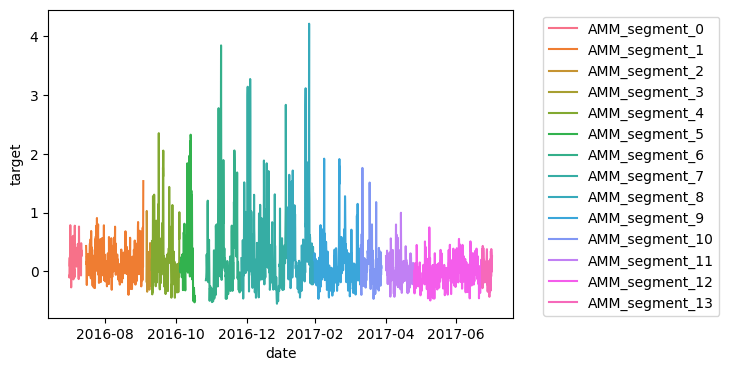

In [7]:
# Filter the data for station ZOT
filtered_data = data[data.station == 'AMM']

# Create the plot
plt.figure(figsize=(6, 4))
sns.lineplot(data=filtered_data, x='date', y='target', hue='group_ids')

# Place the legend to the right of the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

In [8]:
# group by station and group_ids, and calculate the length of each segment
segment_lengths = data.groupby(['station', 'group_ids']).size()

# calculate time difference between consecutive rows
time_diff = data.groupby('station')['date'].diff()

# filter for rows where time difference is greater than 3 hours
gap_lengths = time_diff[time_diff > pd.Timedelta('3 hours')]

In [9]:
segment_lengths = data.groupby(['station', 'group_ids'])['date'].apply(lambda x: (x.max() - x.min()).total_seconds() / 3600)

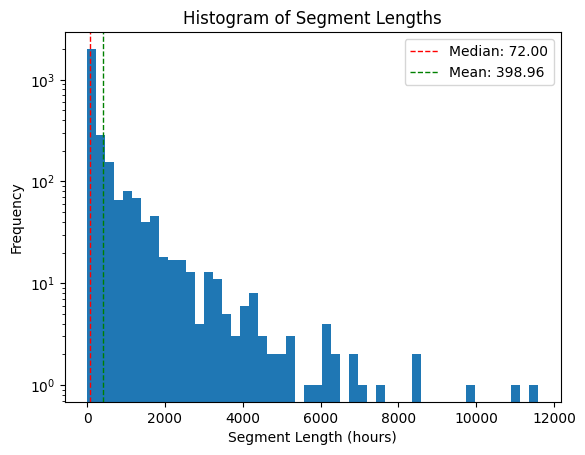

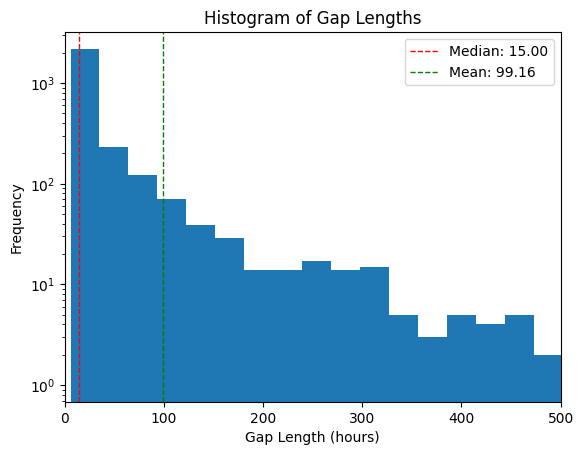

In [10]:
# calculate median, mean, and std for segment lengths
segment_median = np.median(segment_lengths)
segment_mean = np.mean(segment_lengths)

# create histogram of segment lengths with median, mean, and std plotted
plt.hist(segment_lengths, bins=50, log=True)
plt.xlabel('Segment Length (hours)')
plt.ylabel('Frequency')
plt.title('Histogram of Segment Lengths')
plt.axvline(segment_median, color='r', linestyle='dashed', linewidth=1)
plt.axvline(segment_mean, color='g', linestyle='dashed', linewidth=1)
plt.legend(['Median: {:.2f}'.format(segment_median), 'Mean: {:.2f}'.format(segment_mean)])
plt.show()

# calculate median, mean, and std for gap lengths
gap_median = np.median(gap_lengths / pd.Timedelta(hours=1))
gap_mean = np.mean(gap_lengths / pd.Timedelta(hours=1))

# create histogram of gap lengths with median, mean, and std plotted
plt.hist(gap_lengths / pd.Timedelta(hours=1), bins=1000, log=True)
plt.xlabel('Gap Length (hours)')
plt.ylabel('Frequency')
plt.title('Histogram of Gap Lengths')
plt.axvline(gap_median, color='r', linestyle='dashed', linewidth=1)
plt.axvline(gap_mean, color='g', linestyle='dashed', linewidth=1)
plt.legend(['Median: {:.2f}'.format(gap_median), 'Mean: {:.2f}'.format(gap_mean)])
plt.xlim([0, 500])
plt.show()

In [11]:
# group by station and group_ids, and calculate the time span of each segment in hours
segment_lengths = data.groupby(['station', 'group_ids'])['date'].apply(lambda x: (x.max() - x.min()).total_seconds() / 3600)

In [12]:
total_segments = len(segment_lengths)
print(f'Total number of segments: {total_segments}')

result_df = pd.DataFrame(index=range(7, 25), columns=stations)

for i in range(7*24, 57*24, 7*24):
    days = int(i/24)
    for s in stations:
        # Filter the 'segment_lengths' series by the current station,
        # and then count the number of segments longer than 'i' hours.
        num_segments_longer_than_i = sum(segment_lengths[s] >= i)
        result_df.loc[days, s] = num_segments_longer_than_i

# Print the result DataFrame
result_df.dropna()

Total number of segments: 2886


,ABZ,ALE,AMA,AMM,ASP,BEI,BOT,BSL,DEL,EGB,...,SAO,SCH,SGP,UAE,PRL,VAR,VHL,VIE,WAL,ZOT
7,34,28,16,12,31,17,18,13,12,11,...,12,53,44,8,16,110,11,18,37,15
14,20,6,6,9,27,11,12,12,4,6,...,7,46,22,4,9,89,8,17,32,15
21,14,3,3,8,25,7,6,11,0,3,...,5,38,14,1,8,72,6,14,26,14
28,13,0,0,5,21,5,4,11,0,3,...,3,30,10,1,5,62,5,13,22,12
35,10,0,0,4,21,4,2,10,0,3,...,0,25,6,1,4,58,3,11,19,11
42,8,0,0,2,21,3,0,9,0,3,...,0,24,4,1,3,54,2,10,17,11
49,8,0,0,2,16,2,0,9,0,3,...,0,24,3,1,3,45,1,7,15,9
56,5,0,0,1,10,1,0,8,0,1,...,0,20,1,1,3,35,0,3,15,9


In [13]:
pd.options.mode.chained_assignment = None

def create_gaps(seq, gap_size):
    start = np.random.randint(0, len(seq) - gap_size)
    end = start + gap_size
    mask = np.ones(len(seq), dtype=bool)
    mask[start:end] = False
    return mask

# sequence_length = 112 # 2 weeks
# min_gap_size = 24 # 3 days
# max_gap_size = 56 # 1 week
# dir_name = 'data_two_week_seq'

sequence_length = 224 # 4 weeks
min_gap_size = 56 # 7 days
max_gap_size = 112 # 2 week
dir_name = 'data_four_week_seq'

os.makedirs(dir_name)

# Loop over each unique group
for group_id in tqdm(data.group_ids.unique()):
    group_data = data[data.group_ids == group_id]
    
    # Exclude groups shorter than sequence_length
    if len(group_data) < sequence_length:
        continue

    # Create HDF5 file for the group
    with h5py.File(f'{dir_name}/{group_id}.hdf5', 'w') as h5file:
        # Use a sliding window to split the group data into sequences of length sequence_length
        for start in range(len(group_data) - sequence_length + 1):
            end = start + sequence_length
            split_data = group_data.iloc[start:end].copy()

            # Create gap
            gap_size = np.random.randint(low=min_gap_size, high=max_gap_size)
            split_data['mask'] = create_gaps(split_data['target'], gap_size)
            
            # Fill targets in the gap using the average value of targets outside the gap
            split_data['avg_target'] = split_data['target']
            outside_gap_data = split_data.loc[split_data['mask'], 'target']
            split_data.loc[~split_data['mask'], 'avg_target'] = outside_gap_data.mean()

            observation_data = split_data[['date', 'avg_target', 'target', 'mask']]
            covariate_data = split_data[['date'] + feature_list]

            # Convert 'date' column to unix time (number of seconds since 1970-01-01 00:00:00)
            observation_data['date'] = observation_data['date'].map(pd.Timestamp.timestamp)
            covariate_data['date'] = covariate_data['date'].map(pd.Timestamp.timestamp)

            # Convert booleans to int
            observation_data = observation_data.astype({'mask': 'int'})

            # Appending with pandas hdf is very slow
            # observation_data.to_hdf(f'{dir_name}/{group_id}.hdf5', key=f'observations_{start}', mode='a')
            # covariate_data.to_hdf(f'{dir_name}/{group_id}.hdf5', key=f'covariates_{start}', mode='a')

            # Save the split data to the HDF5 file
            h5file.create_dataset(f'{start}/observations', data=observation_data)
            h5file.create_dataset(f'{start}/covariates', data=covariate_data)

  0%|          | 0/2886 [00:00<?, ?it/s]

In [14]:
covariate_data.head()

,date,co,c5h8,c10h16,nh3,no,no2,so2,d2m,t2m,...,aermr11,latitude,longitude,altitude,env_type_coastal,env_type_remote,env_type_rural,env_type_rural_regional_background,env_type_urban,env_type_urban_background
476801,1.257206e+09,-0.320431,-0.237714,-0.266642,-0.621093,-0.223860,-0.789394,-0.285701,-1.064644,-1.082823,...,-0.489944,60.8,89.35,123,0,1,0,0,0,0
476802,1.257217e+09,-0.321970,-0.236866,-0.262830,-0.621450,-0.221807,-0.806244,-0.289067,-1.076037,-1.105097,...,-0.489944,60.8,89.35,123,0,1,0,0,0,0
476803,1.257228e+09,-0.321489,-0.237040,-0.258574,-0.621688,-0.220619,-0.819521,-0.290617,-1.100425,-1.100781,...,-0.489859,60.8,89.35,123,0,1,0,0,0,0
476804,1.257239e+09,-0.319583,-0.236518,-0.253999,-0.621309,-0.222482,-0.819491,-0.291658,-1.070532,-1.111438,...,-0.488042,60.8,89.35,123,0,1,0,0,0,0
476805,1.257250e+09,-0.320835,-0.235966,-0.256395,-0.621248,-0.223850,-0.817441,-0.291872,-1.072181,-1.106324,...,-0.481806,60.8,89.35,123,0,1,0,0,0,0


In [15]:
observation_data.head()

,date,avg_target,target,mask
476801,1.257206e+09,-0.436290,-0.436290,1
476802,1.257217e+09,-0.430278,-0.430278,1
476803,1.257228e+09,-0.431544,-0.431544,1
476804,1.257239e+09,-0.470519,-0.470519,1
476805,1.257250e+09,-0.497154,-0.497154,1


In [16]:
data_splits = [0.8, 0.1, 0.1]

# Group files by station
files_by_station = defaultdict(list)
for f in os.scandir(dir_name):
    if f.is_file() and f.name.endswith('.hdf5'):
        station = f.name.split('_')[0]
        files_by_station[station].append(f.path)

# Shuffle the files within each station and split according to data_splits
train_files = []
val_files = []
test_files = []
random.seed(42)
for station, files in files_by_station.items():
    random.shuffle(files)
    train_ratio, val_ratio = data_splits[:2]
    train_split = int(train_ratio * len(files))
    val_split = train_split + int(val_ratio * len(files))
    train_files.extend(files[:train_split])
    val_files.extend(files[train_split:val_split])
    test_files.extend(files[val_split:])

In [17]:
def get_data_paths(flist):
    ds = []
    for f in tqdm(flist):
        with h5py.File(f, 'r') as h5file:
            for key in h5file.keys():
                ds.append((f, key))
    return ds

train_paths = get_data_paths(train_files)
val_paths = get_data_paths(val_files)
test_paths = get_data_paths(test_files)

  0%|          | 0/354 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

In [18]:
metadata = {
    # 'scaler_params': scaler_params,
    'train': train_paths,
    'val': val_paths,
    'test': test_paths
}

with open(os.path.join(dir_name, 'paths.json'), 'w') as f:
    json.dump(metadata, f, indent=2)

**Positional encoding**

The original Transformer has a positional encoding with division by 10000 to the power of 2i/d in the formula to achieve different scales for each dimension in the positional encoding. This is beneficial because it allows the model to learn to attend to both near and far positions in the sequence. Ref. Attention is all you need. https://arxiv.org/pdf/1706.03762.pdf.

The inclusion of 2π in the positional encoding makes it cyclical between 0 and 1. Position in the array is changed to time of day divided by the period 24 hours in a day normalizing it between 0 and 1. This modification to the standard positional encoding is intended to capture the daily periodicity in the data.

The encoding can be described by eq.

$PE(p, 2i) = \sin\left(2 \pi \frac{t/24}{{10000}^{2i/d}}\right)$

and

$PE(p, 2i + 1) = \cos\left(2 \pi \frac{t/24}{{10000}^{2i/d}}\right)$

Knowing $a^b = \exp(b \log(a))$ where $a$ is $10000$ and $b$ is $-2i/d$ we get:

$PE(p, 2i) = \sin\left(2 \pi \frac{t}{24} \exp\left(-\frac{2i \log(10000)}{d}\right)\right)$

and

$PE(p, 2i + 1) = \cos\left(2 \pi \frac{t}{24} \exp\left(-\frac{2i \log(10000)}{d}\right)\right)$